<a href="https://colab.research.google.com/github/hector6298/Deep-Learning-Collab-notebooks/blob/master/Keypoints_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!git clone https://github.com/Zhongdao/VehicleReIDKeyPointData.git
!unzip "/content/drive/My Drive/Copy of VeRi.zip" 
!pip install --upgrade tensorflow-hub

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: VeRi/image_train/0665_c013_00062130_0.jpg  
  inflating: VeRi/image_train/0665_c013_00062135_0.jpg  
  inflating: VeRi/image_train/0665_c014_00063935_0.jpg  
  inflating: VeRi/image_train/0665_c014_00063940_0.jpg  
  inflating: VeRi/image_train/0665_c014_00063945_0.jpg  
  inflating: VeRi/image_train/0665_c014_00063950_0.jpg  
  inflating: VeRi/image_train/0665_c014_00063955_0.jpg  
  inflating: VeRi/image_train/0665_c014_00063960_0.jpg  
  inflating: VeRi/image_train/0665_c015_00063745_0.jpg  
  inflating: VeRi/image_train/0665_c015_00063750_0.jpg  
  inflating: VeRi/image_train/0665_c015_00063770_0.jpg  
  inflating: VeRi/image_train/0665_c015_00063775_0.jpg  
  inflating: VeRi/image_train/0665_c015_00063790_0.jpg  
  inflating: VeRi/image_train/0665_c015_00063795_0.jpg  
  inflating: VeRi/image_train/0665_c016_00064250_0.jpg  
  inflating: VeRi/image_train/0665_c016_00064255_0.jpg  
  inflating: VeRi/image_tra

In [4]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from numpy import genfromtxt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation

In [5]:
def clean_annotation(annotation_dir, ds_dir):
  files = []
  for r, d, f in os.walk(ds_dir):
    for file in f:
            #print(os.path.join(r, file))
            files.append(os.path.join(r, file))
  annotations = genfromtxt(annotation_dir, delimiter=" ", dtype=str)
  mask = np.ones(len(annotations), dtype=bool)

  for i in range(len(annotations)):
    if f"/content/{annotations[i][0]}" not in files:
      print(f"Deleting {annotations[i][0]}")
      mask[i] = False
  return annotations[mask], files

In [6]:
path_train = '/content/VeRi/image_train'
path_test = '/content/VeRi/image_test'
annotation_train = '/content/VehicleReIDKeyPointData/keypoint_train.txt'
annotation_test = '/content/VehicleReIDKeyPointData/keypoint_test.txt'

print("go for train...")
annotations_train, filestr = clean_annotation(annotation_train, path_train)
print("go for test...")
annotations_test, fileste = clean_annotation(annotation_test, path_test)
print('done!')


go for train...
Deleting VeRi/image_train/0755_c006_00059395_0.jpg
Deleting VeRi/image_train/0755_c006_00059365_0.jpg
Deleting VeRi/image_train/0755_c005_00061075_0.jpg
Deleting VeRi/image_train/0755_c007_00061100_0.jpg
Deleting VeRi/image_train/0755_c010_00059555_0.jpg
Deleting VeRi/image_train/0755_c010_00059565_0.jpg
Deleting VeRi/image_train/0755_c008_00060470_0.jpg
Deleting VeRi/image_train/0755_c011_00059370_0.jpg
Deleting VeRi/image_train/0755_c011_00059390_0.jpg
Deleting VeRi/image_train/0755_c011_00059360_0.jpg
Deleting VeRi/image_train/0755_c011_00059345_0.jpg
Deleting VeRi/image_train/0755_c009_00060415_0.jpg
Deleting VeRi/image_train/0755_c005_00061060_0.jpg
Deleting VeRi/image_train/0755_c006_00059420_0.jpg
Deleting VeRi/image_train/0755_c008_00060455_0.jpg
Deleting VeRi/image_train/0755_c006_00059405_0.jpg
Deleting VeRi/image_train/0755_c004_00060145_0.jpg
Deleting VeRi/image_train/0755_c005_00061035_0.jpg
Deleting VeRi/image_train/0755_c010_00059550_0.jpg
Deleting VeRi/i

In [7]:
annotations_train = np.array(annotations_train)
annotations_test = np.array(annotations_test)

##Keypoint modifications per experiment

In [8]:
annotations2delete = (9,10,11,12,17,18,21,22,23,24,25,26,27,28,29,30,31,32,37,38)
annotations_test = np.delete(annotations_test,annotations2delete,1)
annotations_train = np.delete(annotations_train, annotations2delete, 1)

In [9]:
print(len(annotations_test[0]))
print(len(annotations_train[0]))

22
22


In [10]:
print(f"final train instances: {len(annotations_train)}")
print(f"final test instances: {len(annotations_test)}")

final train instances: 38571
final test instances: 12077


In [11]:
_augmentation_transform = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    zoom_range=(0.85, 1.15),
    fill_mode='constant',
    cval=0.,
)

def apply_augmentation(img):
    img = _augmentation_transform.random_transform(img)
    return img

## Augmentation engine

In [13]:
!pip3 install git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-oacscol0
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-oacscol0
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971107 sha256=dba9eee28f101f4cbe6ebf19095898a635abed6490c0c316434c634014d912ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-0iy5yhz1/wheels/65/3d/94/ee32cbeaa29c473a4db74c2d21904ac747311fdca4732665f0
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [17]:
import imgaug.augmenters as iaa
import imgaug as ia

In [18]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
AugmentationEngine = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-15, 15), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 2.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 5)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 7)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

/usr/local/lib/python3.6/dist-packages/imgaug/imgaug.py:188: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/usr/local/lib/python3.6/dist-packages/imgaug/imgaug.py:188: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


In [19]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self,
               data_dir,
               annotations,
               batch_size=32,
               img_size=(128,128),
               num_channels=3,
               augmentation=None,
               shuffle=True,
               is_training=True):
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.img_size = img_size
    if augmentation is not None:
      self.augmentationEngine = augmentation
    self.shuffle = shuffle
    self.annotations = annotations
    self.n = 0
    self.num_channels = num_channels
    self.is_training = is_training
    if is_training:
      mode = "train"
    else:
      mode = "test"
    print(self.batch_size)
    print(f"size of {mode} set: {len(self.annotations)}")

    self.on_epoch_end()

  def __next__(self):
    batch_x, batch_y = self.__getitem__(self.n)
    self.n += 1
    if self.n >= self.__len__():
      self.on_epoch_end()
    return batch_x, batch_y

  def __len__(self):
    return int(np.ceil(len(self.annotations) / float(self.batch_size)))

  def on_epoch_end(self):
    if self.shuffle == True:
      np.random.shuffle(self.annotations)
    self.n = 0
  
  def __getitem__(self,idx):
    batch_x = np.empty((self.batch_size, *self.img_size, self.num_channels))
    batch_y = np.empty((self.batch_size, len(self.annotations[0])-2))

    batch_files = self.annotations[idx*self.batch_size:(idx+1)*self.batch_size,0]
    anns = self.annotations[idx*self.batch_size:(idx+1)*self.batch_size,1:-1]
    for sample_num in range(len(batch_files)):
      x = cv2.imread(batch_files[sample_num])
      try:
        height, width, _ = x.shape
      except:
        print(batch_files[sample_num])
      x = cv2.resize(x, self.img_size)
      x = x.astype('float32') / 255.0
      y = anns[sample_num].astype('float32')
      if self.is_training and hasattr(self,'augmentationEngineIMG'):
        x, y = self.augmentationEngine(images=x, keypoints=y)

      batch_x[sample_num] = x
      batch_y[sample_num] = y
      
      for i in range(len(batch_y[sample_num])):
        if batch_y[sample_num][i] != -1:
          if i % 2 == 0:
            batch_y[sample_num][i] /= width
          else:
            batch_y[sample_num][i] /= height

    return batch_x, batch_y

In [20]:
EPOCHS = 50
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
IMG_SIZE = (112, 112)
NUM_OUTPUTS = 20

TRAIN_FILE = "/content/VehicleReIDKeyPointData/keypoint_train.txt"
TEST_FILE = "/content/VehicleReIDKeyPointData/keypoint_test.txt"
DATADIR = "/content/"


In [21]:
MODEL_URL = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [22]:

train_generator = DataGenerator(data_dir=DATADIR,
                                annotations=annotations_train,
                                batch_size=64,
                                augmentation=AugmentationEngine,
                                is_training=True,
                                img_size=IMG_SIZE)

test_generator = DataGenerator(data_dir=DATADIR,
                               annotations=annotations_test,
                               batch_size=64,
                               augmentation=None,
                               is_training=False,
                               img_size=IMG_SIZE)

64
size of train set: 38571
64
size of test set: 12077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


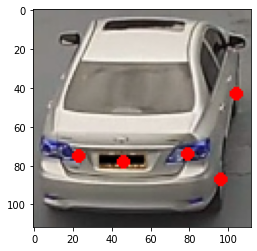

In [23]:
batch_x, batch_y = next(test_generator)
sample_img, points = batch_x[15], batch_y[15]
height, width, _ = sample_img.shape
sample_img2 = sample_img.copy()

for i in range(0, 20, 2):
  #print(i, i+1)
  pt1 = points[i+1]*height
  pt1 = pt1.astype(int)
  pt2 = points[i]*width
  pt2 = pt2.astype(int)
  pt = (pt2, pt1)
  sample_img2 = cv2.circle(sample_img2, pt, 2, (255,0,0), 2) 
plt.imshow(sample_img2)
plt.show()

In [24]:
  @tf.function
  def custom_activation(inputs):
    orig = inputs
    inputs = tf.where(tf.less(orig, 0.), -1., inputs)
    inputs = tf.where(tf.greater(orig, 1.), 1., inputs)
    return  inputs

In [25]:
def get_model(input_shape, output_nodes):
  inputs = tf.keras.layers.Input(shape=input_shape)
  base_model = hub.KerasLayer(MODEL_URL, trainable=True)
  regression_layer = tf.keras.layers.Dense(output_nodes, activation='tanh')

  x = inputs
  x = base_model(x)
  x = regression_layer(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_object = tf.keras.losses.MeanSquaredError()
metrics = [tf.keras.metrics.MeanSquaredError()]

model = get_model((*IMG_SIZE,3), NUM_OUTPUTS)
model.compile(optimizer=optimizer, loss=loss_object, metrics=metrics)

In [27]:
def scheduler(epoch):
  if epoch <= 1:
    return 0.005
  else:
    return 0.0005 * tf.math.exp(0.1 * (10 - epoch))
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/content/logs")

In [28]:
checkpoint_filepath = '/content/drive/My Drive/tmpKeypoints/checkpoint2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mean_squared_error',
    mode='max',
    save_best_only=True)

In [ ]:
model_history = model.fit(x=train_generator,
                          epochs=EPOCHS,
                          validation_data=test_generator,
                          verbose=1,
                          callbacks=[model_checkpoint_callback,scheduler_callback]
                          )


Epoch 1/50
603/603 [==============================] - ETA: 0s - loss: 0.2228 - mean_squared_error: 0.0987WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 116s 192ms/step - loss: 0.2228 - mean_squared_error: 0.0987 - val_loss: 0.2283 - val_mean_squared_error: 0.1352
Epoch 2/50
603/603 [==============================] - ETA: 0s - loss: 0.1332 - mean_squared_error: 0.0614WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.1332 - mean_squared_error: 0.0614 - val_loss: 0.1408 - val_mean_squared_error: 0.0829
Epoch 3/50
603/603 [==============================] - ETA: 0s - loss: 0.0967 - mean_squared_error: 0.0436WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0967 - mean_squared_error: 0.0436 - val_loss: 0.1115 - val_mean_squared_error: 0.0630
Epoch 4/50
603/603 [==============================] - ETA: 0s - loss: 0.0839 - mean_squared_error: 0.0392WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 114s 189ms/step - loss: 0.0839 - mean_squared_error: 0.0392 - val_loss: 0.1053 - val_mean_squared_error: 0.0642
Epoch 5/50
603/603 [==============================] - ETA: 0s - loss: 0.0739 - mean_squared_error: 0.0355WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0739 - mean_squared_error: 0.0355 - val_loss: 0.1006 - val_mean_squared_error: 0.0646
Epoch 6/50
603/603 [==============================] - ETA: 0s - loss: 0.0672 - mean_squared_error: 0.0331WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0672 - mean_squared_error: 0.0331 - val_loss: 0.0968 - val_mean_squared_error: 0.0645
Epoch 7/50
603/603 [==============================] - ETA: 0s - loss: 0.0603 - mean_squared_error: 0.0295WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0603 - mean_squared_error: 0.0295 - val_loss: 0.0949 - val_mean_squared_error: 0.0653
Epoch 8/50
603/603 [==============================] - ETA: 0s - loss: 0.0553 - mean_squared_error: 0.0267WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0553 - mean_squared_error: 0.0267 - val_loss: 0.0900 - val_mean_squared_error: 0.0624
Epoch 9/50
603/603 [==============================] - ETA: 0s - loss: 0.0503 - mean_squared_error: 0.0234WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0503 - mean_squared_error: 0.0234 - val_loss: 0.0875 - val_mean_squared_error: 0.0613
Epoch 10/50
603/603 [==============================] - ETA: 0s - loss: 0.0463 - mean_squared_error: 0.0207WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0463 - mean_squared_error: 0.0207 - val_loss: 0.0872 - val_mean_squared_error: 0.0622
Epoch 11/50
603/603 [==============================] - ETA: 0s - loss: 0.0427 - mean_squared_error: 0.0182WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0427 - mean_squared_error: 0.0182 - val_loss: 0.0873 - val_mean_squared_error: 0.0632
Epoch 12/50
603/603 [==============================] - ETA: 0s - loss: 0.0400 - mean_squared_error: 0.0164WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0400 - mean_squared_error: 0.0164 - val_loss: 0.0892 - val_mean_squared_error: 0.0659
Epoch 13/50
603/603 [==============================] - ETA: 0s - loss: 0.0369 - mean_squared_error: 0.0139WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 116s 192ms/step - loss: 0.0369 - mean_squared_error: 0.0139 - val_loss: 0.0931 - val_mean_squared_error: 0.0704
Epoch 14/50
603/603 [==============================] - ETA: 0s - loss: 0.0343 - mean_squared_error: 0.0120WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 116s 192ms/step - loss: 0.0343 - mean_squared_error: 0.0120 - val_loss: 0.0848 - val_mean_squared_error: 0.0627
Epoch 15/50
603/603 [==============================] - ETA: 0s - loss: 0.0330 - mean_squared_error: 0.0112WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 116s 192ms/step - loss: 0.0330 - mean_squared_error: 0.0112 - val_loss: 0.0884 - val_mean_squared_error: 0.0670
Epoch 16/50
603/603 [==============================] - ETA: 0s - loss: 0.0312 - mean_squared_error: 0.0100WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 116s 192ms/step - loss: 0.0312 - mean_squared_error: 0.0100 - val_loss: 0.0880 - val_mean_squared_error: 0.0670
Epoch 17/50
603/603 [==============================] - ETA: 0s - loss: 0.0298 - mean_squared_error: 0.0091WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 116s 193ms/step - loss: 0.0298 - mean_squared_error: 0.0091 - val_loss: 0.0872 - val_mean_squared_error: 0.0667
Epoch 18/50
603/603 [==============================] - ETA: 0s - loss: 0.0284 - mean_squared_error: 0.0082WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 116s 193ms/step - loss: 0.0284 - mean_squared_error: 0.0082 - val_loss: 0.0858 - val_mean_squared_error: 0.0657
Epoch 19/50
603/603 [==============================] - ETA: 0s - loss: 0.0268 - mean_squared_error: 0.0069WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 116s 193ms/step - loss: 0.0268 - mean_squared_error: 0.0069 - val_loss: 0.0853 - val_mean_squared_error: 0.0656
Epoch 20/50
603/603 [==============================] - ETA: 0s - loss: 0.0256 - mean_squared_error: 0.0061WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 116s 192ms/step - loss: 0.0256 - mean_squared_error: 0.0061 - val_loss: 0.0854 - val_mean_squared_error: 0.0660
Epoch 21/50
603/603 [==============================] - ETA: 0s - loss: 0.0246 - mean_squared_error: 0.0055WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 116s 192ms/step - loss: 0.0246 - mean_squared_error: 0.0055 - val_loss: 0.0853 - val_mean_squared_error: 0.0663
Epoch 22/50
603/603 [==============================] - ETA: 0s - loss: 0.0246 - mean_squared_error: 0.0058WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 116s 193ms/step - loss: 0.0246 - mean_squared_error: 0.0058 - val_loss: 0.0838 - val_mean_squared_error: 0.0652
Epoch 23/50
603/603 [==============================] - ETA: 0s - loss: 0.0231 - mean_squared_error: 0.0046WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 117s 193ms/step - loss: 0.0231 - mean_squared_error: 0.0046 - val_loss: 0.0858 - val_mean_squared_error: 0.0675
Epoch 24/50
603/603 [==============================] - ETA: 0s - loss: 0.0227 - mean_squared_error: 0.0045WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0227 - mean_squared_error: 0.0045 - val_loss: 0.0834 - val_mean_squared_error: 0.0653
Epoch 25/50
603/603 [==============================] - ETA: 0s - loss: 0.0220 - mean_squared_error: 0.0040WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0220 - mean_squared_error: 0.0040 - val_loss: 0.0848 - val_mean_squared_error: 0.0670
Epoch 26/50
603/603 [==============================] - ETA: 0s - loss: 0.0221 - mean_squared_error: 0.0044WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0221 - mean_squared_error: 0.0044 - val_loss: 0.0839 - val_mean_squared_error: 0.0663
Epoch 27/50
603/603 [==============================] - ETA: 0s - loss: 0.0210 - mean_squared_error: 0.0035WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0210 - mean_squared_error: 0.0035 - val_loss: 0.0838 - val_mean_squared_error: 0.0664
Epoch 28/50
603/603 [==============================] - ETA: 0s - loss: 0.0206 - mean_squared_error: 0.0033WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0206 - mean_squared_error: 0.0033 - val_loss: 0.0835 - val_mean_squared_error: 0.0662
Epoch 29/50
603/603 [==============================] - ETA: 0s - loss: 0.0202 - mean_squared_error: 0.0030WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0202 - mean_squared_error: 0.0030 - val_loss: 0.0823 - val_mean_squared_error: 0.0653
Epoch 30/50
603/603 [==============================] - ETA: 0s - loss: 0.0207 - mean_squared_error: 0.0038WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0207 - mean_squared_error: 0.0038 - val_loss: 0.0836 - val_mean_squared_error: 0.0668
Epoch 31/50
603/603 [==============================] - ETA: 0s - loss: 0.0196 - mean_squared_error: 0.0028WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0196 - mean_squared_error: 0.0028 - val_loss: 0.0831 - val_mean_squared_error: 0.0665
Epoch 32/50
603/603 [==============================] - ETA: 0s - loss: 0.0200 - mean_squared_error: 0.0034WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 114s 190ms/step - loss: 0.0200 - mean_squared_error: 0.0034 - val_loss: 0.0819 - val_mean_squared_error: 0.0653
Epoch 33/50
603/603 [==============================] - ETA: 0s - loss: 0.0191 - mean_squared_error: 0.0026WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0191 - mean_squared_error: 0.0026 - val_loss: 0.0823 - val_mean_squared_error: 0.0659
Epoch 34/50
603/603 [==============================] - ETA: 0s - loss: 0.0195 - mean_squared_error: 0.0032WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 114s 190ms/step - loss: 0.0195 - mean_squared_error: 0.0032 - val_loss: 0.0838 - val_mean_squared_error: 0.0675
Epoch 35/50
603/603 [==============================] - ETA: 0s - loss: 0.0186 - mean_squared_error: 0.0024WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0186 - mean_squared_error: 0.0024 - val_loss: 0.0823 - val_mean_squared_error: 0.0661
Epoch 36/50
603/603 [==============================] - ETA: 0s - loss: 0.0190 - mean_squared_error: 0.0029WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0190 - mean_squared_error: 0.0029 - val_loss: 0.0809 - val_mean_squared_error: 0.0648
Epoch 37/50
603/603 [==============================] - ETA: 0s - loss: 0.0182 - mean_squared_error: 0.0022WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0182 - mean_squared_error: 0.0022 - val_loss: 0.0818 - val_mean_squared_error: 0.0658
Epoch 38/50
603/603 [==============================] - ETA: 0s - loss: 0.0180 - mean_squared_error: 0.0021WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0180 - mean_squared_error: 0.0021 - val_loss: 0.0818 - val_mean_squared_error: 0.0659
Epoch 39/50
603/603 [==============================] - ETA: 0s - loss: 0.0179 - mean_squared_error: 0.0021WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0179 - mean_squared_error: 0.0021 - val_loss: 0.0820 - val_mean_squared_error: 0.0662
Epoch 40/50
603/603 [==============================] - ETA: 0s - loss: 0.0177 - mean_squared_error: 0.0020WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 116s 192ms/step - loss: 0.0177 - mean_squared_error: 0.0020 - val_loss: 0.0816 - val_mean_squared_error: 0.0659
Epoch 41/50
603/603 [==============================] - ETA: 0s - loss: 0.0186 - mean_squared_error: 0.0029WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0186 - mean_squared_error: 0.0029 - val_loss: 0.0834 - val_mean_squared_error: 0.0678
Epoch 42/50
603/603 [==============================] - ETA: 0s - loss: 0.0182 - mean_squared_error: 0.0026WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0182 - mean_squared_error: 0.0026 - val_loss: 0.0814 - val_mean_squared_error: 0.0658
Epoch 43/50
603/603 [==============================] - ETA: 0s - loss: 0.0174 - mean_squared_error: 0.0019WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0174 - mean_squared_error: 0.0019 - val_loss: 0.0828 - val_mean_squared_error: 0.0673
Epoch 44/50
603/603 [==============================] - ETA: 0s - loss: 0.0173 - mean_squared_error: 0.0018WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0173 - mean_squared_error: 0.0018 - val_loss: 0.0820 - val_mean_squared_error: 0.0666
Epoch 45/50
603/603 [==============================] - ETA: 0s - loss: 0.0181 - mean_squared_error: 0.0026WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 191ms/step - loss: 0.0181 - mean_squared_error: 0.0026 - val_loss: 0.0809 - val_mean_squared_error: 0.0655
Epoch 46/50
603/603 [==============================] - ETA: 0s - loss: 0.0171 - mean_squared_error: 0.0018WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0171 - mean_squared_error: 0.0018 - val_loss: 0.0813 - val_mean_squared_error: 0.0660
Epoch 47/50
603/603 [==============================] - ETA: 0s - loss: 0.0171 - mean_squared_error: 0.0018WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0171 - mean_squared_error: 0.0018 - val_loss: 0.0809 - val_mean_squared_error: 0.0656
Epoch 48/50
603/603 [==============================] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.0017WARNING:tensorflow:Can save best model only with val_mean_io_u_9 available, skipping.


603/603 [==============================] - 115s 190ms/step - loss: 0.0170 - mean_squared_error: 0.0017 - val_loss: 0.0806 - val_mean_squared_error: 0.0654
Epoch 49/50
209/603 [=========>....................] - ETA: 1:04 - loss: 0.0170 - mean_squared_error: 0.0017

In [ ]:
def plot_metrics(model_history):
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  acc = model_history.history['mean_squared_error']
  val_acc = model_history.history['val_mean_squared_error']
  epochs = range(EPOCHS)

  fig, axs = plt.subplots(1,2)
  axs[0].plot(epochs, loss)
  axs[0].plot(epochs, val_loss)
  axs[0].set_title('loss')
  axs[1].plot(epochs, acc)
  axs[1].plot(epochs, val_acc)
  axs[1].set_title('MSE')

  plt.plot()

In [ ]:
plot_metrics(model_history)

In [ ]:
batch_x, batch_y = next(test_generator)
sample_img, points = batch_x[20], batch_y[20]
pred = model(sample_img[tf.newaxis,...])
print(pred)
print(points)

In [ ]:
pred = pred.numpy()
print(pred)

In [ ]:
height, width, _ = sample_img.shape
sample_img1 = sample_img.copy()
for i in range(0, 20, 2):
  #print(i, i+1)
  pt1 = pred[0][i+1]*height
  pt1 = pt1.astype(int)
  pt2 = pred[0][i]*width
  pt2 = pt2.astype(int)
  pt = (pt2, pt1)
  sample_img1 = cv2.circle(sample_img1, pt, 1, (255,0,0), 2) 
plt.imshow(sample_img1)
plt.show()

In [ ]:
height, width, _ = sample_img.shape
print(points)
sample_img2 = sample_img.copy()

for i in range(0, 20, 2):
  #print(i, i+1)
  pt1 = points[i+1]*height
  pt1 = pt1.astype(int)
  pt2 = points[i]*width
  pt2 = pt2.astype(int)
  pt = (pt2, pt1)
  sample_img2 = cv2.circle(sample_img2, pt, 2, (255,0,0), 2) 
plt.imshow(sample_img2)
plt.show()

In [ ]:
model.save("whole_keypointDNN32x32.h5")

In [ ]:
!mv "whole_keypointDNN32x32.h5" "drive/My Drive/whole_keypointDNN32x32.h5"